# Preamble

In [51]:
%load_ext autoreload
%autoreload 2

# disable parallelization for BLAS and co.
from nalabtools.utils.parallelization import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)

# general
import re
import collections
import pickle

# data
import numpy as np
import pandas as pd

# ml / stats
import scipy
import sklearn
import statsmodels.stats.multitest

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nalab
import nalabtools

# init notebook files
import nalabtools.utils.misc
nb = nalabtools.utils.misc.NotebookContext("butterfly___martin_004_deepinsight")

# init matplotlib defaults (for Nima)
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/mgbckr/mnt/nalab/workspaces/nalab-tools/src/nalabtools/utils/parallelization.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


In [2]:
import time

In [3]:
def format_duration(totsec):
    h = totsec//3600
    m = (totsec%3600) // 60
    sec =(totsec%3600)%60 #just for reference
    print("%dh %dm %ds" %(h,m,sec))

In [4]:
import rpy2
rpy2.__version__

'3.1.0'

In [5]:
%load_ext rpy2.ipython

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [6]:
%%R
R.home()

[1] "/home/mgbckr/miniconda3/envs/analysis3.7/lib/R"


# Load data

In [7]:
import pathlib
import nalabdata.fcs.load
import nalabdata.fcs.meta

In [8]:
overwrite = True

# immune clock
tmp_fcs_path = pathlib.Path(nb.file("tmp_fcs_immuneclock.pickle"))
if not overwrite and tmp_fcs_path.exists():

    print("Loading from temp file")
    data_immuneclock_meta, data_immuneclock_fcs = pickle.load(open(path, "rb"))
    
else:
    
    print("Loading from FCS files; this may take a while ...")
    
    path = pathlib.Path("../data/_large/fcs/immune_clock/AllImmuneClock")
    files = list((path / "Training").glob("*")) + list((path / "Validation").glob("*"))

    selected_files = files
    data_immuneclock_meta = nalabdata.fcs.meta.meta_from_filenames(selected_files, context="immune_clock")
    data_immuneclock_fcs = nalabdata.fcs.load.load_fcs(
        selected_files,  
#         cell_filter="granulocytes", 
        n_cells_sample=10000,
        n_jobs=64)
    
    pickle.dump((data_immuneclock_meta, data_immuneclock_fcs), open(tmp_fcs_path, "wb"))
    
print("Done")

Loading from FCS files; this may take a while ...


R[write to console]: Loading required package: foreach

R[write to console]: Loading required package: iterators

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:flowCore’:

    filter


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Done


In [40]:
print("done")

done


In [42]:
data_immuneclock_meta

group  patient   cell_range stimulation  timepoint  \
file_index                                                            
0             training  ptlg001  cd235-cd61-      unstim          3   
1             training  ptlg001  cd235-cd61-      unstim          4   
2             training  ptlg001  cd235-cd61-      unstim          2   
3             training  ptlg001  cd235-cd61-      unstim          1   
4             training  ptlg002  cd235-cd61-      unstim          4   
...                ...      ...          ...         ...        ...   
119         validation  ptlg033  cd235-cd61-      unstim          1   
120         validation  ptlg034  cd235-cd61-      unstim          2   
121         validation  ptlg034  cd235-cd61-      unstim          3   
122         validation  ptlg034  cd235-cd61-      unstim          4   
123         validation  ptlg034  cd235-cd61-      unstim          1   

            gestational_age_delivery  gestational_age_sample  \
file_index                                                     
0                                 40                      27   
1                                 40                      47   
2                                 40                      16   
3                                 40                      11   
4                                 38                      45   
...                              ...                     ...   
119                               41                      12   
120                               38                      17   
121                               38                      25   
122                               38                      45   
123                               38                      11   

                                                     filename  \
file_index                                                      
0           Gates_PTLG001_2_Unstim_CD235-CD61-_unstim_3d__...   
1           Gates_PTLG001_3_Unstim_CD235-CD61-_unstim_pp__...   
2           Gates_PTLG001_1_Unstim_CD235-CD61-_unstim_2nd_...   
3           Gates_PTLG001_BL_Unstim_CD235-CD61-_unstim_1st...   
4           Gates_PTLG002_3_Unstim_CD235-CD61-_unstim_pp__...   
...                                                       ...   
119         Gates_PTLG033_BL_Unstim_CD235-CD61-_Unstim_BL_...   
120         Gates_PTLG034_1_Unstim_CD235-CD61-_Unstim_1__2...   
121         Gates_PTLG034_2_Unstim_CD235-CD61-_Unstim_2__3...   
122         Gates_PTLG034_3_Unstim_CD235-CD61-_Unstim_3__p...   
123         Gates_PTLG034_BL_Unstim_CD235-CD61-_Unstim_BL_...   

                                                         path  
file_index                                                     
0           ../data/_large/fcs/immune_clock/AllImmuneClock...  
1           ../data/_large/fcs/immune_clock/AllImmuneClock...  
2           ../data/_large/fcs/immune_clock/AllImmuneClock...  
3           ../data/_large/fcs/immune_clock/AllImmuneClock...  
4           ../data/_large/fcs/immune_clock/AllImmuneClock...  
...                                                       ...  
119         ../data/_large/fcs/immune_clock/AllImmuneClock...  
120         ../data/_large/fcs/immune_clock/AllImmuneClock...  
121         ../data/_large/fcs/immune_clock/AllImmuneClock...  
122         ../data/_large/fcs/immune_clock/AllImmuneClock...  
123         ../data/_large/fcs/immune_clock/AllImmuneClock...  

[124 rows x 9 columns]

In [41]:
data_immuneclock_fcs

Time  Event_length     Y89Di       BC1       BC2       BC3  \
file_index                                                                    
0           15.021835      2.644121  0.000000  5.299105  3.083258  3.129366   
0           14.325681      2.350926  0.000000  4.574649  2.046452  1.584293   
0           15.251908      2.388011  0.061903  4.333765  1.096982  1.673853   
0           11.932388      2.848273  0.000000  5.183850  2.671616  2.546589   
0           13.859132      3.319126  0.000000  5.000349  2.015594  2.334167   
...               ...           ...       ...       ...       ...       ...   
123         14.102384      1.879864  0.063723  5.535585  5.488010  5.257456   
123         14.692201      1.609438  0.000000  4.315148  4.560135  4.233449   
123         12.262716      2.615433  0.000000  4.355396  4.484286  4.154144   
123         12.062113      2.230814  0.000000  3.531401  3.553535  3.376309   
123         15.156283      2.142112  0.000000  4.126525  4.358587  4.079935   

                 BC4       BC5       BC6  CD235ab_CD61  ...      CCR7  \
file_index                                              ...             
0           5.533096  2.899643  5.463048      0.000000  ...  2.297114   
0           4.923020  2.247490  4.833333      0.085235  ...  0.764891   
0           4.692643  1.415107  4.422677      0.000000  ...  1.712811   
0           5.311275  2.984572  5.309551      0.058535  ...  1.355086   
0           5.217107  2.237741  5.139281      0.445814  ...  1.724904   
...              ...       ...       ...           ...  ...       ...   
123         3.826691  3.630986  2.839782      1.096664  ...  4.102893   
123         2.539077  1.960440  1.700209      0.081184  ...  1.965235   
123         2.441822  1.758250  1.471098      0.000000  ...  1.846188   
123         1.670115  0.980055  0.500813      0.009578  ...  0.000000   
123         2.251044  2.315382  1.420663      0.184090  ...  1.263672   

                CD15      CCR2     HLADR      CD14      CD56      DNA1  \
file_index                                                               
0           5.002074  2.342148  1.096706  0.418254  1.542481  4.924871   
0           0.673837  4.179603  3.559384  2.101476  0.701105  3.692334   
0           0.194677  0.142754  0.000000  0.000000  1.604089  3.993714   
0           4.490222  0.986458  0.835857  0.294668  0.687832  4.532347   
0           1.380400  3.888444  5.433616  1.440001  3.138482  4.164249   
...              ...       ...       ...       ...       ...       ...   
123         4.046600  1.936634  1.760696  1.104119  3.605907  3.708895   
123         3.446394  0.800253  0.616061  0.000000  0.296205  3.311110   
123         2.722010  0.264497  0.000000  0.000000  0.875476  3.609655   
123         0.000000  0.118676  0.000000  0.000000  2.119946  3.459501   
123         3.076055  0.349900  0.000000  0.000000  0.235964  3.702209   

                DNA2   Pt195Di  beadDist  
file_index                                
0           5.543000  0.000000  3.145537  
0           4.390877  0.000000  3.002126  
0           4.879944  0.000000  3.093632  
0           5.149003  0.094334  3.050866  
0           4.918432  0.003396  3.087740  
...              ...       ...       ...  
123         4.640345  0.017896  2.965420  
123         4.262562  0.089436  2.721890  
123         4.183247  0.000000  2.649740  
123         4.274602  0.000000  2.511085  
123         4.209206  0.000000  2.668595  

[1240000 rows x 55 columns]

In [11]:
# data_immuneclock_meta

# Postprocessing


In [12]:
columns_immuneclock = nalabdata.fcs.load.filter_columns(data_immuneclock_fcs.columns)

In [13]:
data_immuneclock_fcs_post = data_immuneclock_fcs.copy()

In [14]:
# scale each patient
# data_immuneclock_fcs_post = data_immuneclock_fcs_post.groupby(level=0).apply(
#     lambda df: pd.DataFrame(sklearn.preprocessing.RobustScaler().fit_transform(df.values), columns=df.columns))

In [15]:
import sklearn.pipeline
import sklearn.compose
preprocessing = sklearn.pipeline.make_pipeline(
    # select relevant columns
    sklearn.compose.ColumnTransformer([("filter", "passthrough", [c in columns_immuneclock for c in data_immuneclock_fcs.columns])]),
    # 0 - 1
    sklearn.preprocessing.MinMaxScaler()
)

In [16]:
preprocessing.fit(data_immuneclock_fcs.values)
data_features = preprocessing.transform(data_immuneclock_fcs_post.values)

## Batch correction

In [17]:
batches, idx = data_immuneclock_meta.loc[data_immuneclock_fcs.index, "group"].factorize()

In [18]:
%%R -i data_features -i batches -o corrected
library(limma)
corrected <- t(removeBatchEffect(t(data_features), batches))

In [19]:
data_featurs_limma = sklearn.preprocessing.MinMaxScaler().fit_transform(corrected)

In [20]:
%%R -i data_features -i batches -o corrected
library(sva)
corrected <- t(ComBat(t(data_features), batches))

R[write to console]: Loading required package: mgcv

R[write to console]: Loading required package: nlme

R[write to console]: 
Attaching package: ‘nlme’


R[write to console]: The following object is masked from ‘package:dplyr’:

    collapse


R[write to console]: This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.

R[write to console]: Loading required package: genefilter

R[write to console]: Loading required package: BiocParallel

R[write to console]: Found2batches

R[write to console]: Adjusting for0covariate(s) or covariate level(s)



Standardizing Data across genes


R[write to console]: Fitting L/S model and finding priors

R[write to console]: Finding parametric adjustments

R[write to console]: Adjusting the Data




In [21]:
data_featurs_combat = sklearn.preprocessing.MinMaxScaler().fit_transform(corrected)

In [22]:
# scale each patient
data_features_robust = data_immuneclock_fcs_post.groupby(level=0).apply(
    lambda df: pd.DataFrame(sklearn.preprocessing.RobustScaler().fit_transform(df.values), columns=df.columns))
data_features_robust = sklearn.preprocessing.MinMaxScaler().fit_transform(data_features_robust)

In [23]:
# scale each patient
data_features_standard = data_immuneclock_fcs_post.groupby(level=0).apply(
    lambda df: pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(df.values), columns=df.columns))
data_features_standard = sklearn.preprocessing.MinMaxScaler().fit_transform(data_features_standard)

In [46]:
# scale each patient
data_features_quantile = data_immuneclock_fcs_post.groupby(level=0).apply(
    lambda df: pd.DataFrame(sklearn.preprocessing.QuantileTransformer().fit_transform(df.values), columns=df.columns))
data_features_quantile = sklearn.preprocessing.MinMaxScaler().fit_transform(data_features_quantile)

# Helper functions

In [24]:
def get_album(data_features):

    import fitsne
    import butterfly.deepinsight.album2

    start = time.time()

    t = butterfly.deepinsight.album2.SingleCellTransformer(
        size=128, 
        embedding_algorithm=lambda X: fitsne.FItSNE(np.ascontiguousarray(X), nthreads=64),
    #     embedding_algorithm=None,
        store_embeddings=True,
        means=True)
    X_album = t.fit_transform(data_features, data_immuneclock_fcs.index.values)

    duration = time.time() - start
    print(format_duration(duration))
    return X_album

In [25]:
def plot_pca(X_album):
    import sklearn.decomposition
    pca = sklearn.decomposition.PCA(n_components=10)
    a = X_album[:,1,:,:].reshape((-1, 128 * 128))
    a[np.isnan(a)] = 0
    emb = pca.fit_transform(a)
    plt.figure(figsize=(16,16))
    sns.scatterplot(emb[:,0], emb[:,1], hue=data_immuneclock_meta.timepoint, s=250, style=data_immuneclock_meta.group.values)
    for i in range(emb.shape[0]):
        plt.annotate(f"{data_immuneclock_meta.patient.values[i]} ({i})", (emb[i,0], emb[i,1]))

In [26]:
def plot_photos(X_album, d=0, selected=5, plot=True, plot_log=True, random_state="head"):
    
    if isinstance(selected, int):
        if random_state == "head":
            selected = list(range(selected))
        else:
            if random_state != "random":
                rs = np.random.RandomState(random_state)
            else:
                rs = np.random.RandomState()
            selected = sorted(rs.randint(0, X_album.shape[0], selected))
        
    if plot:
        fig, axes = plt.subplots(1, len(selected), figsize=(len(selected) * (4 + .5), 4), sharey=True, sharex=True)
        for i, s in enumerate(selected):
            ax = axes[i]
            sns.heatmap(X_album[s, d, :], ax=ax, cbar=s == selected[-1])
            ax.set_title(s)
        
    if plot_log:
        fig, axes = plt.subplots(1, len(selected), figsize=(len(selected) * (4 + .5), 4), sharey=True, sharex=True)
        for i, s in enumerate(selected):
            ax = axes[i]
            sns.heatmap(np.log10(X_album[s, d, :] + 0.00001), ax=ax, cbar=s == selected[-1])
            ax.set_title(s)

In [27]:
selected = [112,98,20,6,88]
def visualize(album):
    plot_photos(album, d=0, selected=selected, random_state=None)
    plot_photos(album, d=33, selected=selected, random_state=None)
    plot_pca(album)

# Get albums

In [ ]:
album_limma = get_album(data_featurs_limma)
album_combat = get_album(data_featurs_combat)

Embedding
Rotating


group:     0, row:   0: : 0it [00:00, ?it/s]/home/mgbckr/mnt/nalab/workspaces/nalab-butterfly/src/butterfly/deepinsight/album2.py:220: RuntimeWarning: Mean of empty slice.
  album[i_g, 1:, i, j] = group_data[feature_idx, :].mean(axis=0)
/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
group:     0, row:   7: : 0it [00:00, ?it/s]

Images


group:   123, row: 127: : 124it [06:07,  2.97s/it]


In [ ]:
album_robust = get_album(data_features_robust)
album_standard = get_album(data_features_standard)

In [ ]:
album_quantile = get_album(data_features_quantile)

In [56]:
album_no = get_album(data_features)

Embedding
Rotating


group:     0, row:   0: : 0it [00:00, ?it/s]/home/mgbckr/mnt/nalab/workspaces/nalab-butterfly/src/butterfly/deepinsight/album2.py:220: RuntimeWarning: Mean of empty slice.
  album[i_g, 1:, i, j] = group_data[feature_idx, :].mean(axis=0)
/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
group:     0, row:   3: : 0it [00:00, ?it/s]

Images


group:   123, row: 127: : 124it [06:47,  3.29s/it]

0h 59m 10s
None


In [57]:
print("test")

test


In [ ]:
# Visualize

In [59]:
data_immuneclock_fcs.columns

Index(['Time', 'Event_length', 'Y89Di', 'BC1', 'BC2', 'BC3', 'BC4', 'BC5',
       'BC6', 'CD235ab_CD61', 'CD45', 'I127Di', 'Ba138Di', 'CD66', 'Ce140Di',
       'CD7', 'CD19', 'CD45RA', 'CD11b', 'CD4', 'CD8a', 'CD11c', 'CD123',
       'CREB', 'STAT5', 'p38', 'TCRgd', 'STAT1', 'STAT3', 'S6', 'CXCR3',
       'CD161', 'CD33', 'MAPKAPK2', 'Tbet', 'Dy161Di', 'FoxP3', 'Dy163Di',
       'IkB', 'CD16', 'NFkB', 'ERK', 'CCR9', 'CD25', 'CD3', 'CCR7', 'CD15',
       'CCR2', 'HLADR', 'CD14', 'CD56', 'DNA1', 'DNA2', 'Pt195Di', 'beadDist'],
      dtype='object')

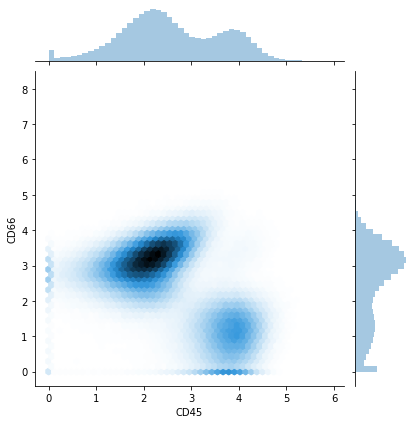

In [63]:
 sns.jointplot(data_immuneclock_fcs.CD45, data_immuneclock_fcs.CD66, kind="hex");

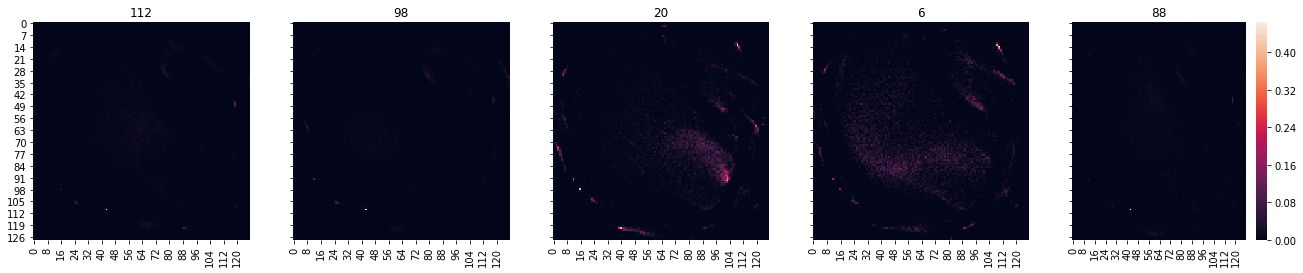

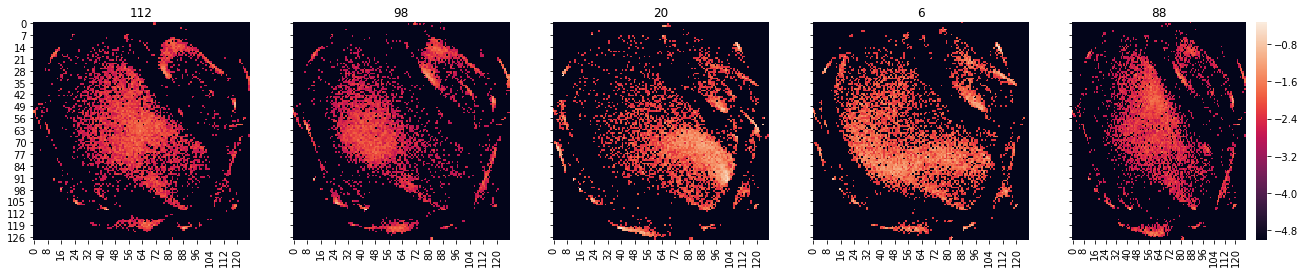

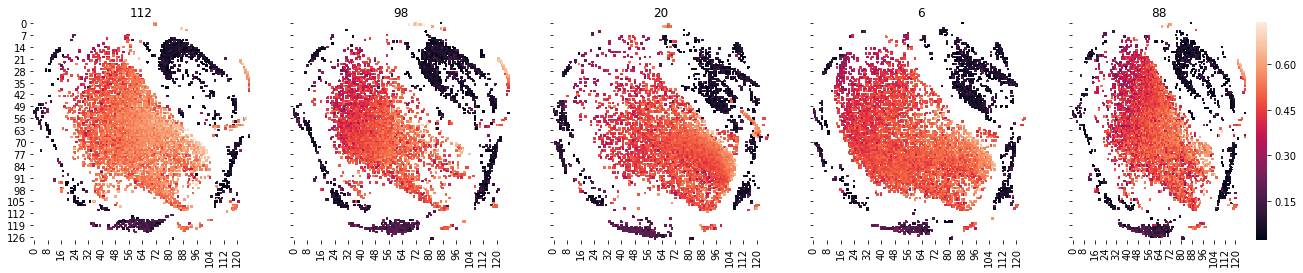

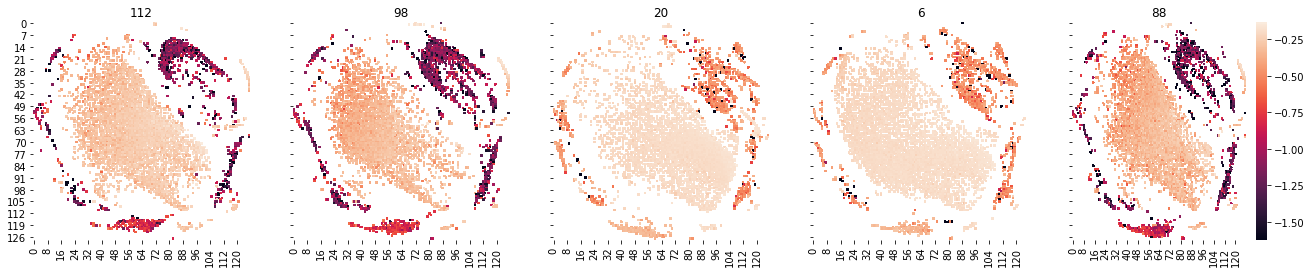

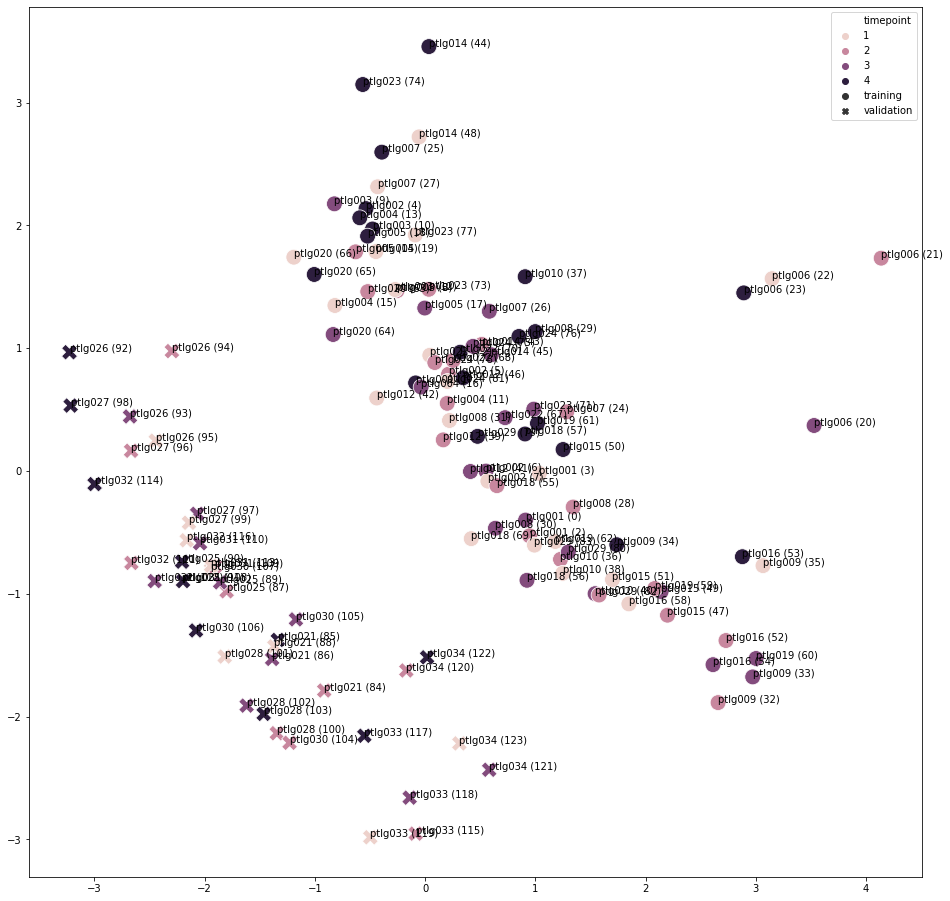

In [30]:
visualize(album_limma)

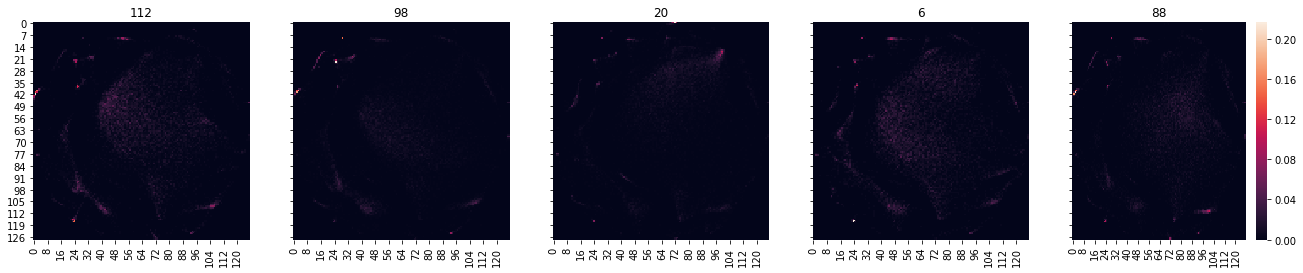

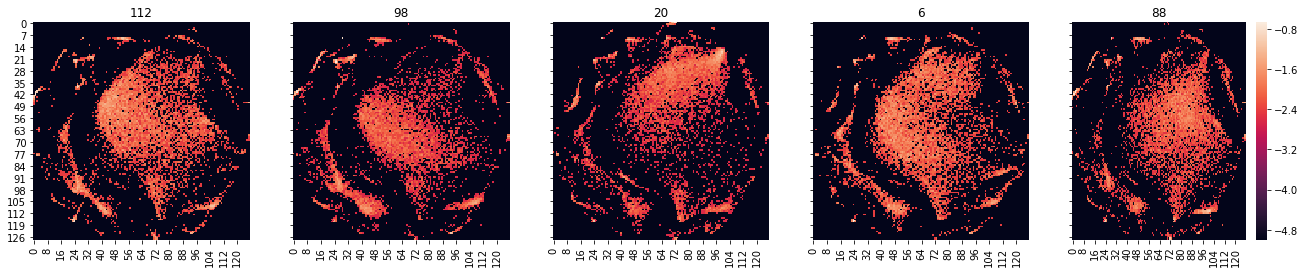

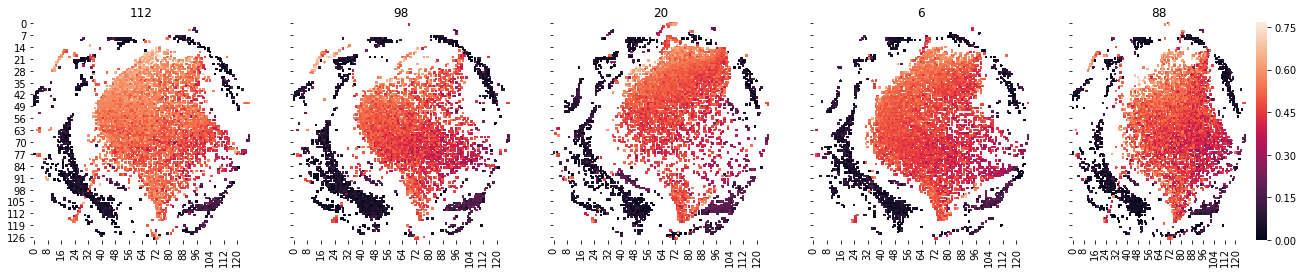

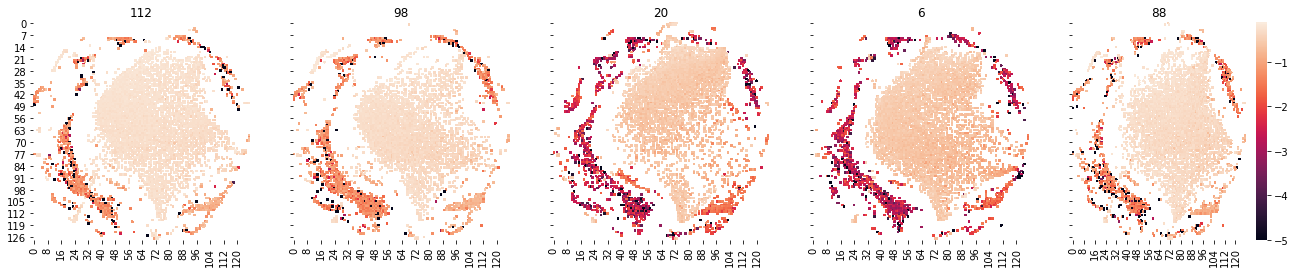

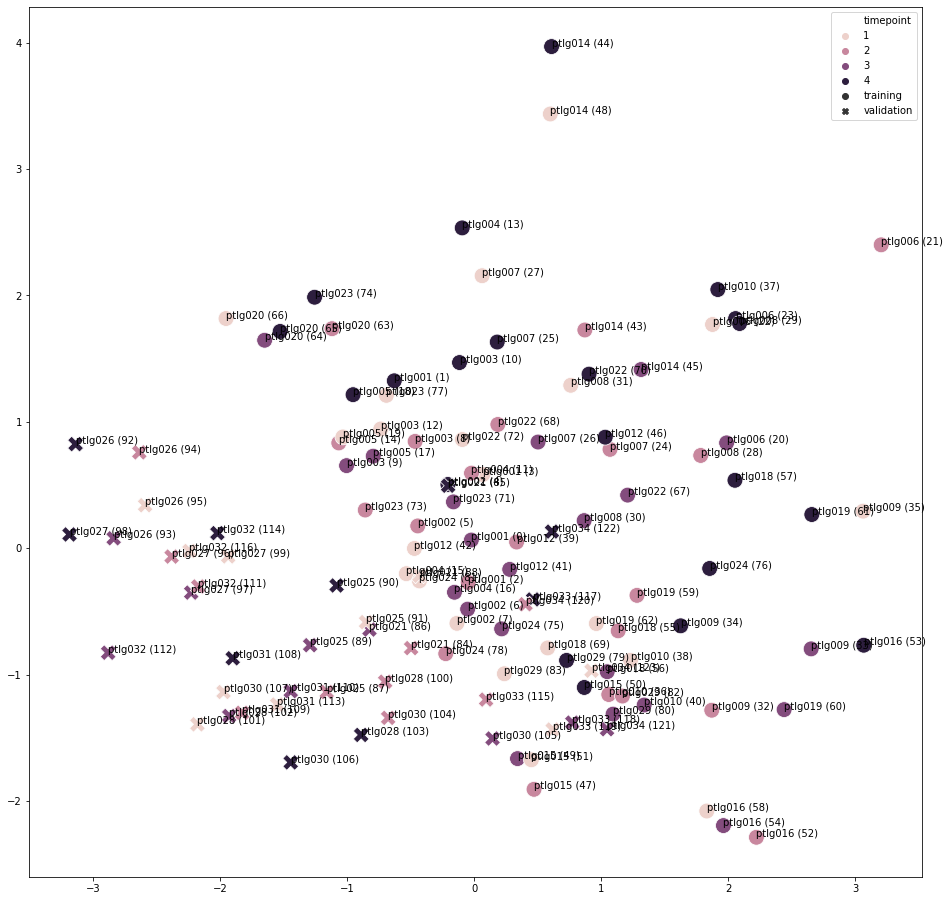

In [31]:
visualize(album_combat)

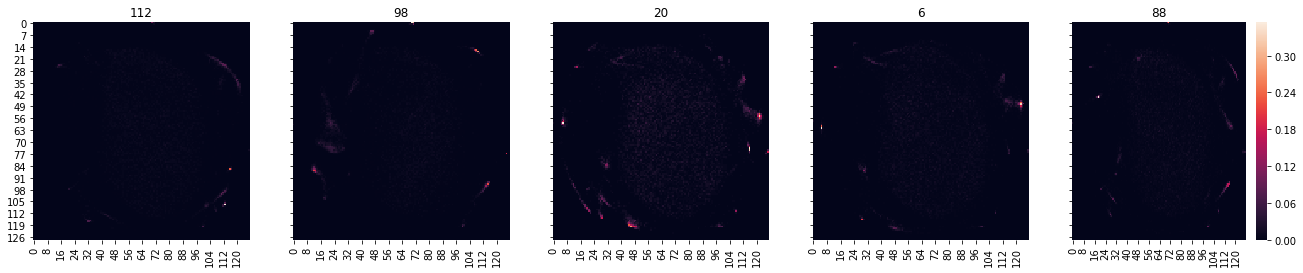

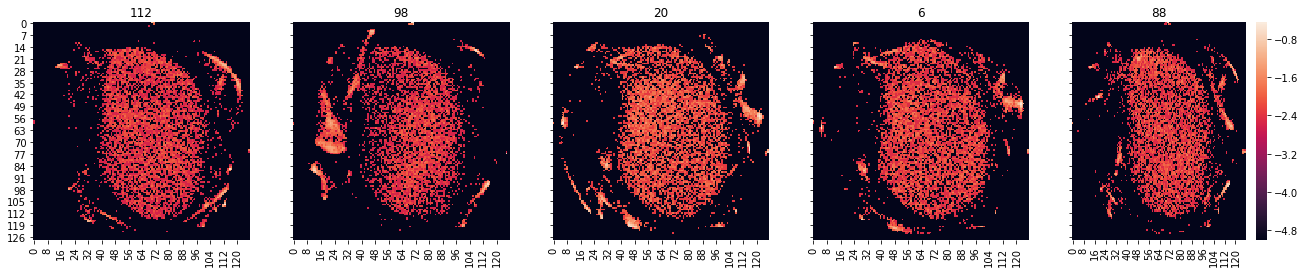

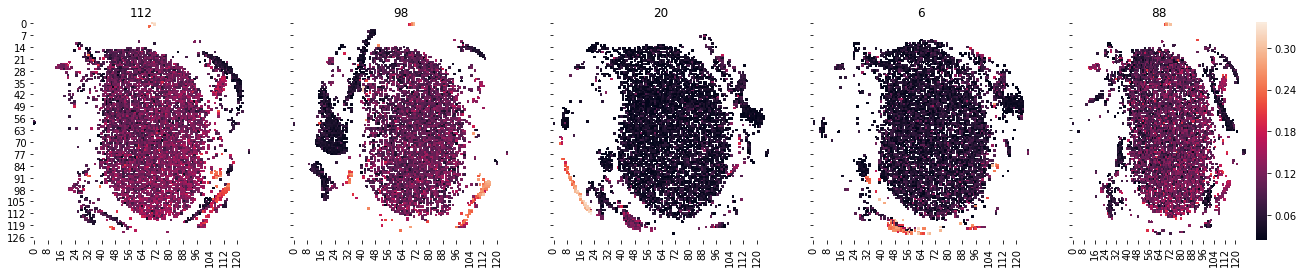

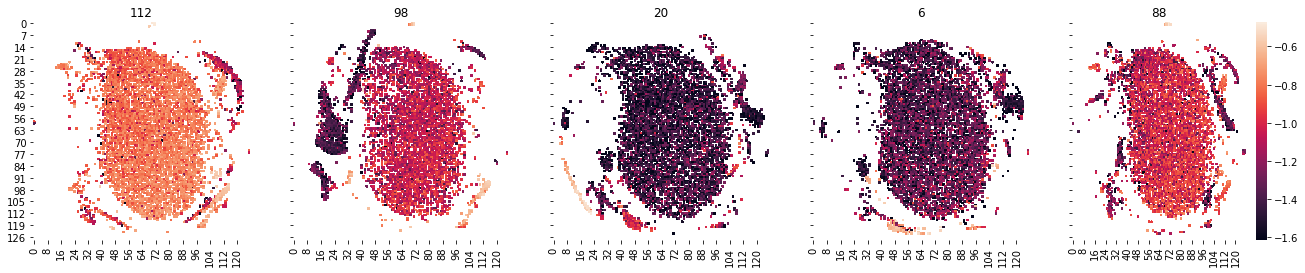

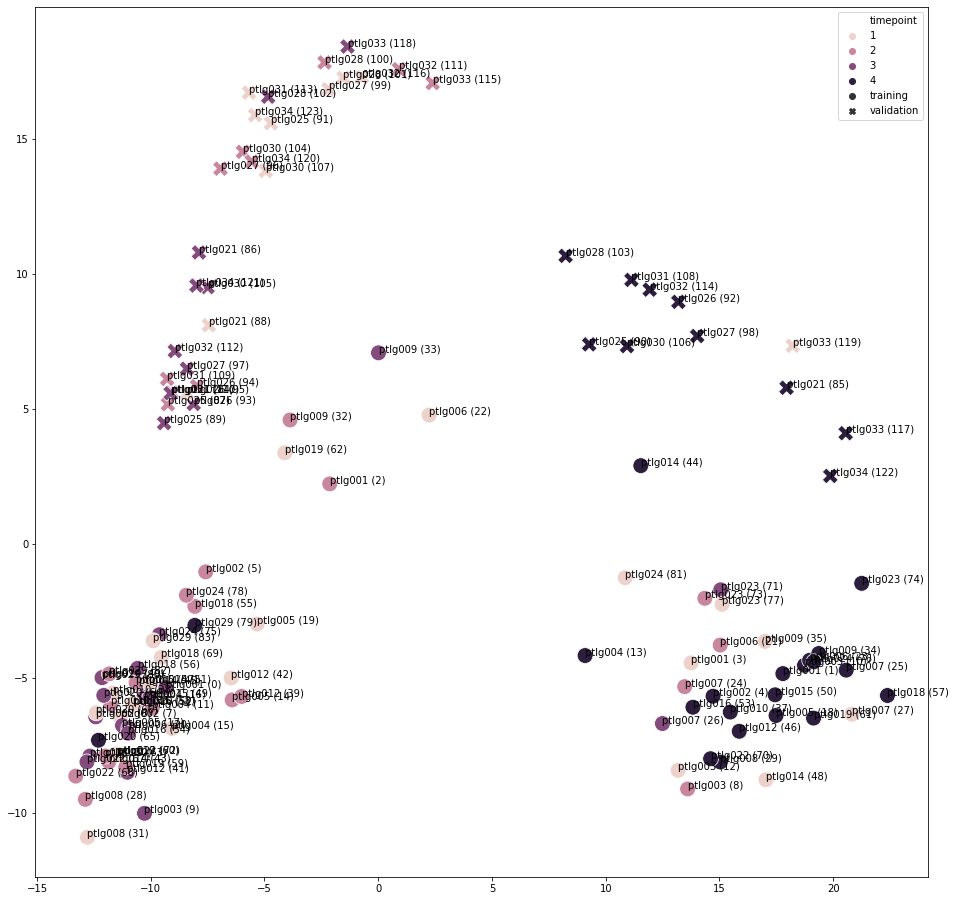

In [37]:
visualize(album_robust)

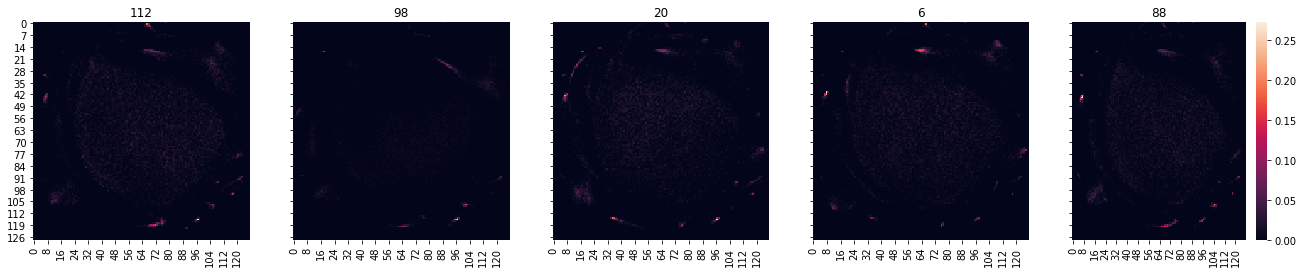

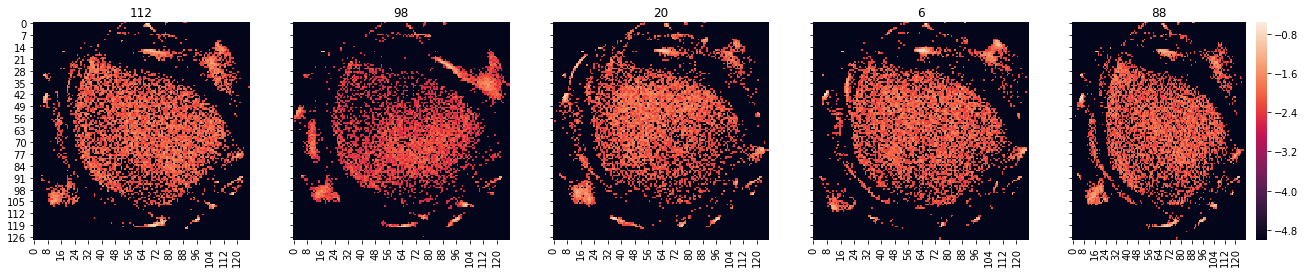

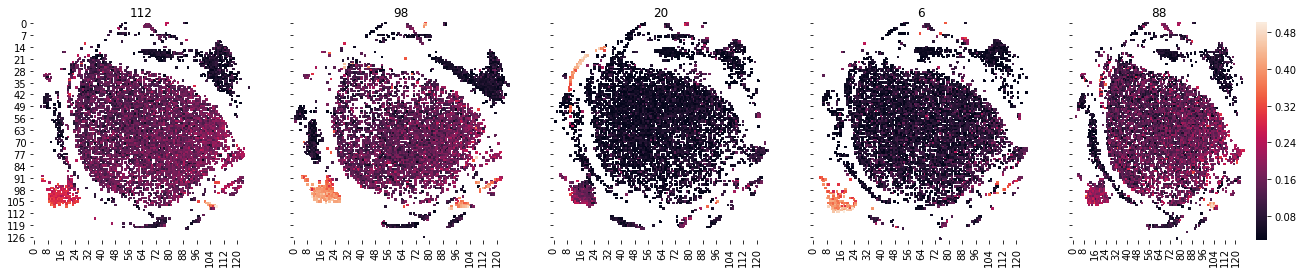

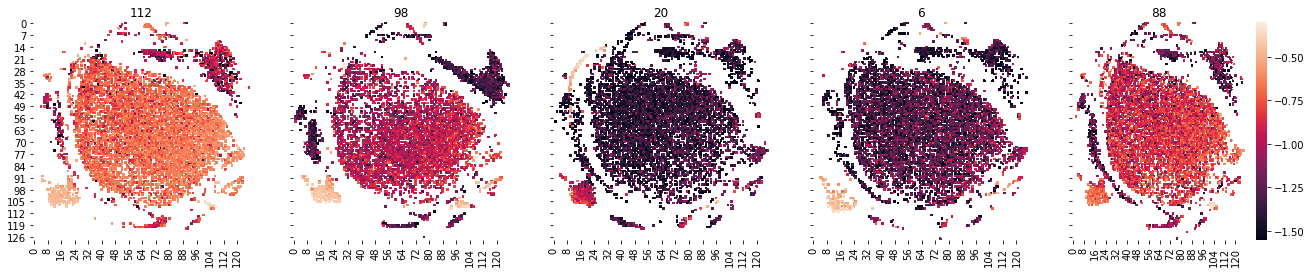

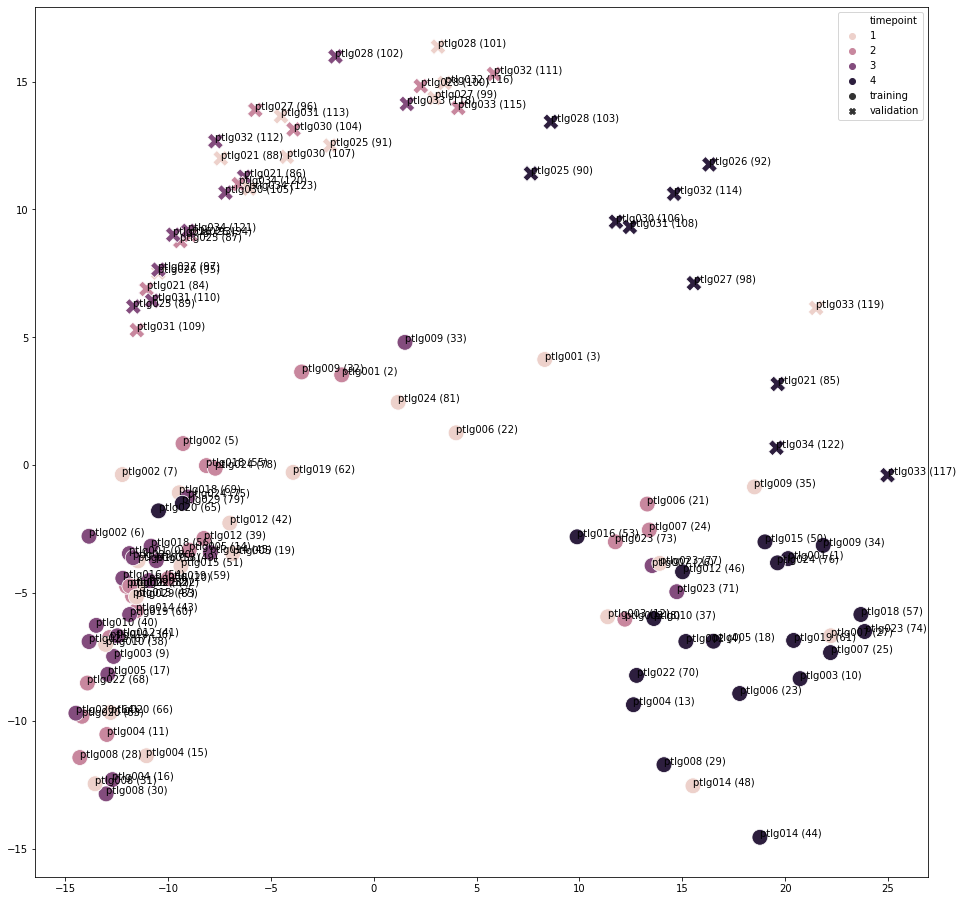

In [38]:
visualize(album_standard)

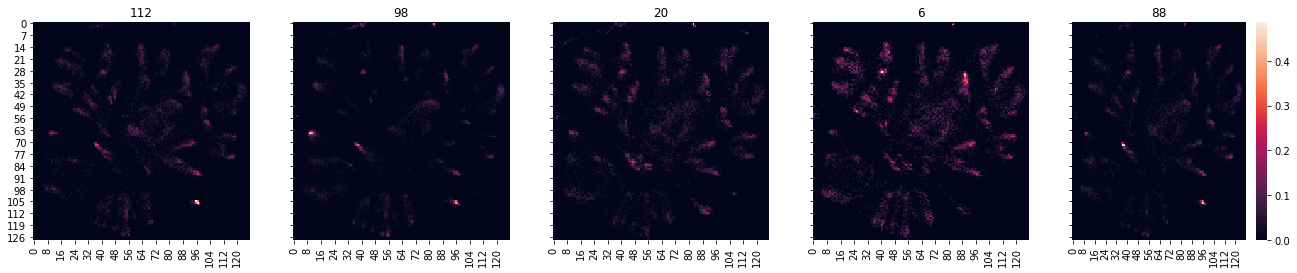

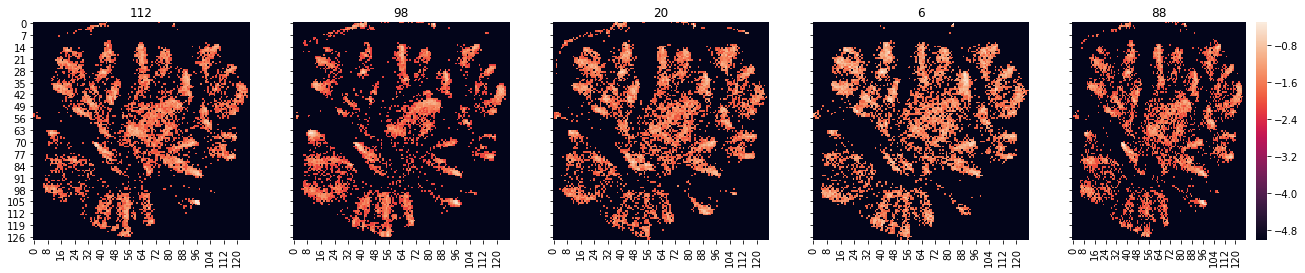

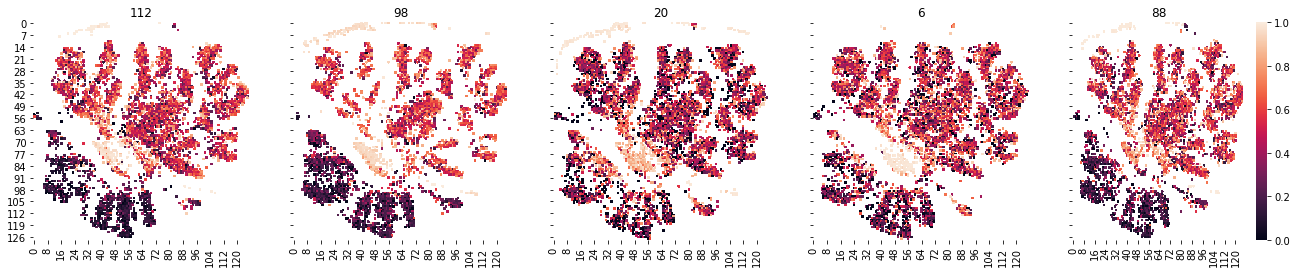

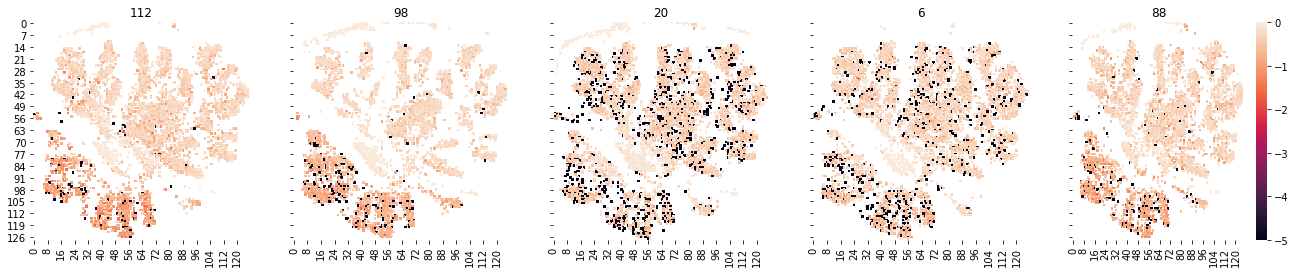

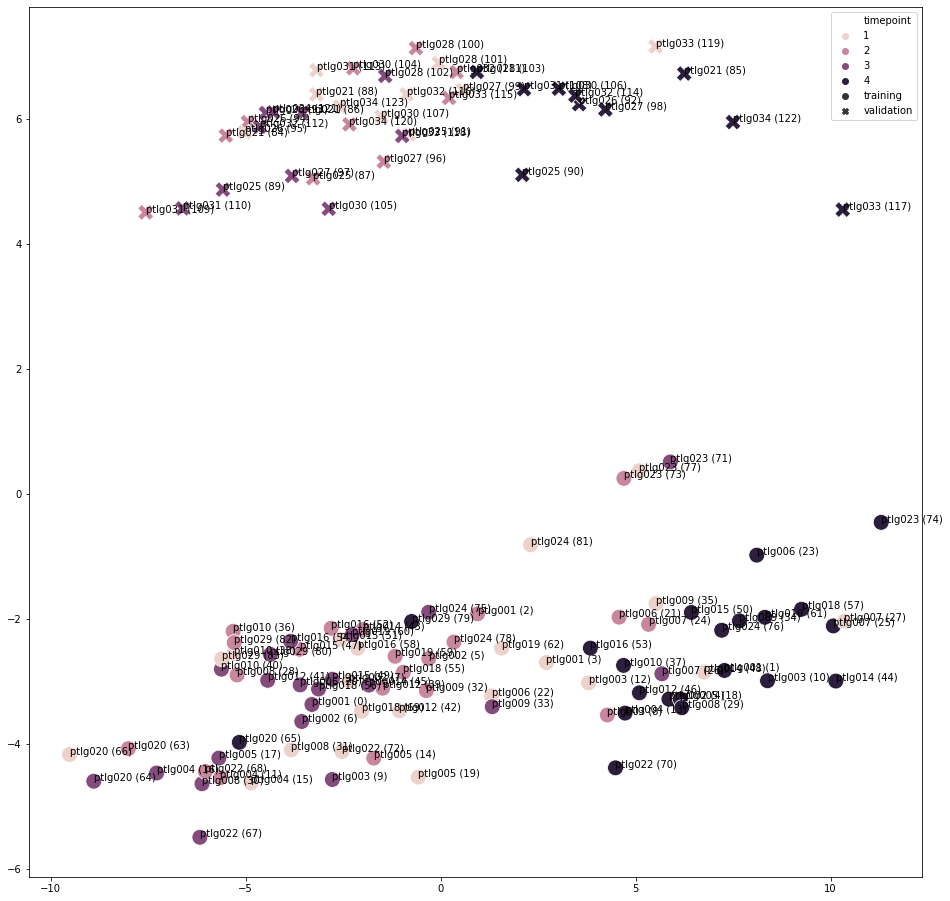

In [52]:
visualize(album_quantile)

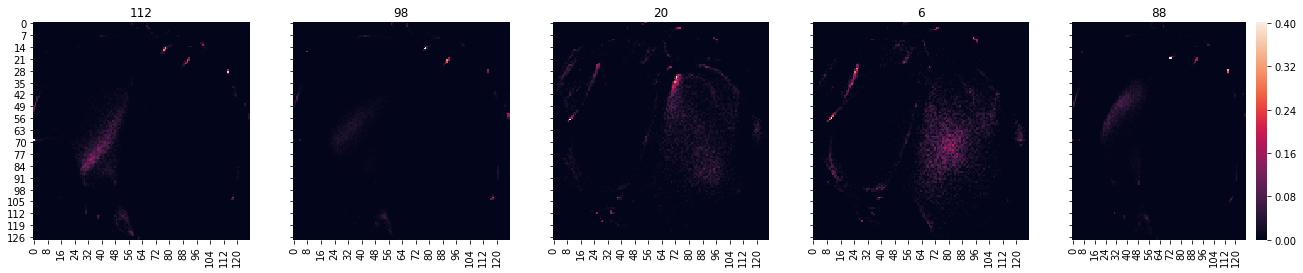

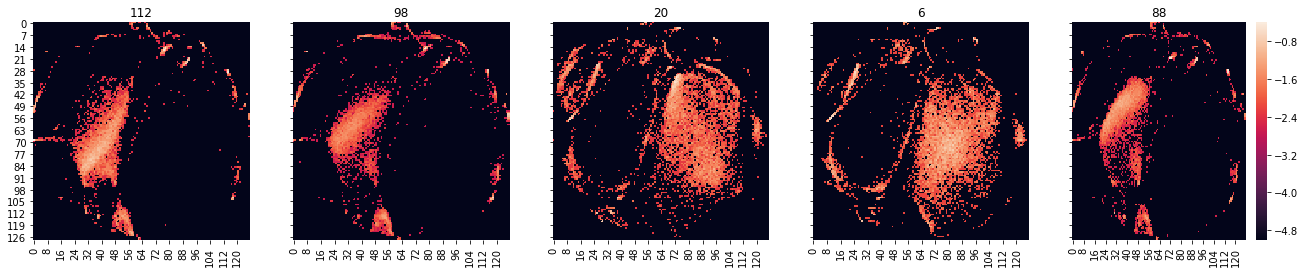

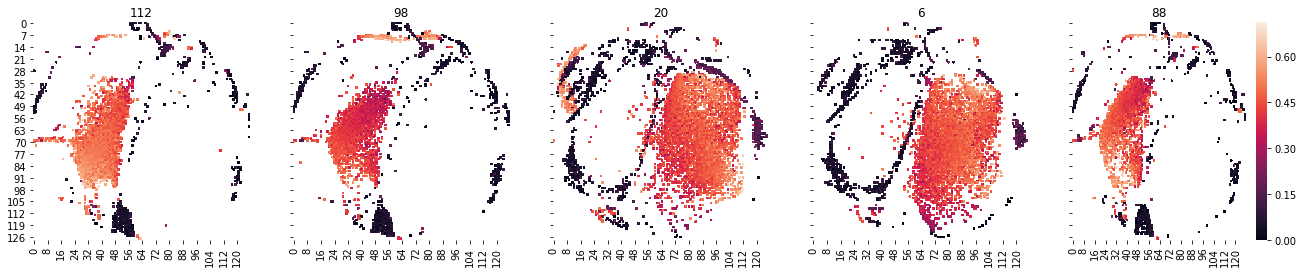

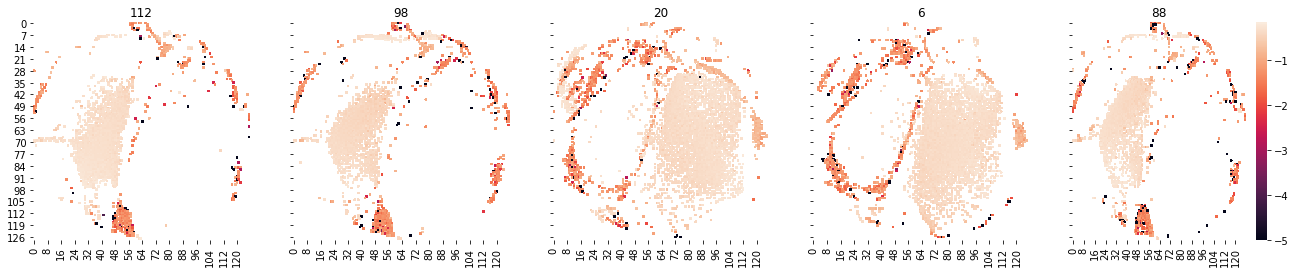

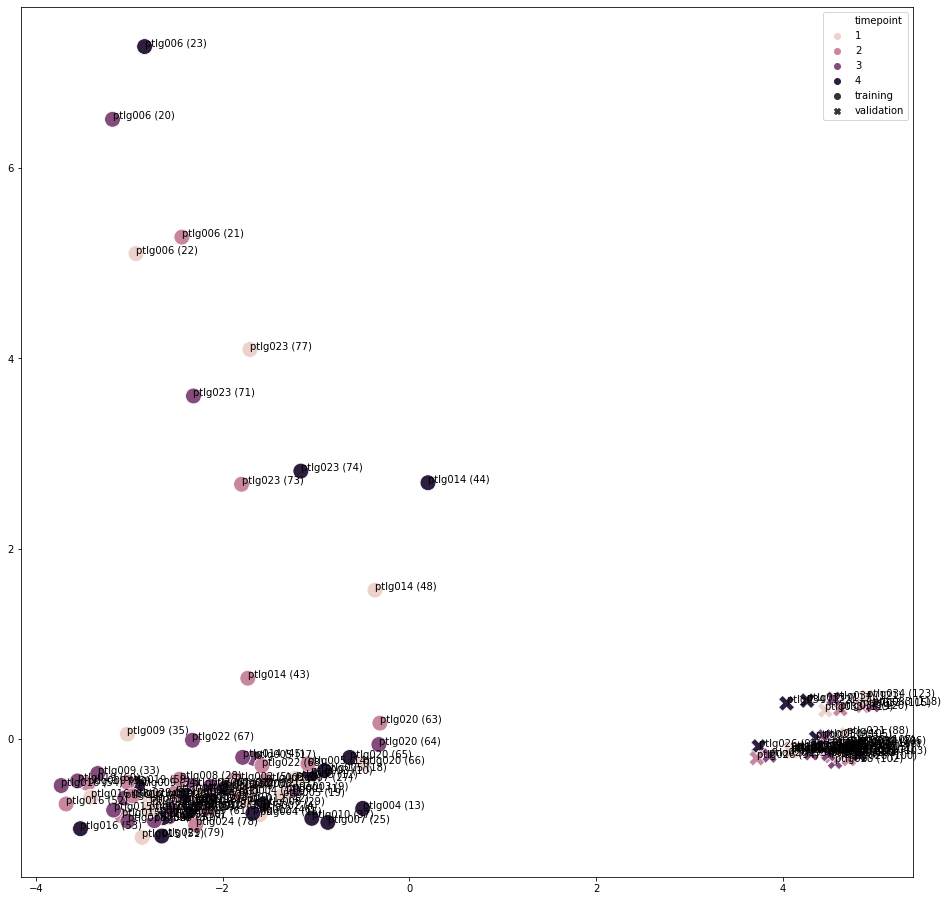

In [58]:
visualize(album_no)